## Проект для "Викишоп" с BERT

## Описанеие проекта

Задача:

* Создать модель для поиска токсичных комментариев.

* Модель должна классифицировать комментарии на позитивные и негативные.

* Метрика качества F1  должна быть не меннее 0.75.



Используемый набор данных содержит разметки токсичных комментариев.


Выполнение задачи будет происходить с использованием BERT

## Import

In [1]:
'''
!pip install transformers
'''

'\n!pip install transformers\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize




from nltk.corpus import stopwords
import re


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline





from sklearn.metrics import f1_score

import transformers

import torch 
from tqdm import notebook



plt.style.use('dark_background')   # Изменим внешний вид будующих таблиц
rs = 1667 # На эту переменную будут ссылаться все указания random_state

In [3]:

path_loc = 'E:/NLPProject/toxic_comments.csv'
path_yp = '/datasets/toxic_comments.csv'


try:
    main = pd.read_csv(path_loc)
except:
    main = pd.read_csv(path_yp)



## EDA

Первичный анализ имеющихся данных:

In [4]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
main.head(5)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


### Class balanse

доля токсичных комментариев: 0.11310497114027364


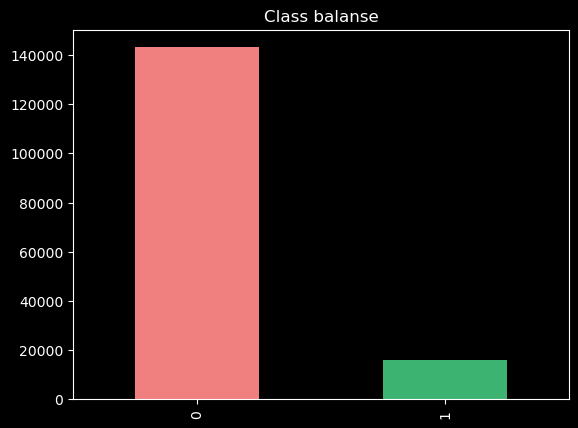

In [6]:
main['toxic'].unique()
main['toxic'].value_counts().plot(kind = 'bar', color = ['lightcoral','mediumseagreen'])

print('доля токсичных комментариев:',main['toxic'].value_counts()[1] / main['toxic'].value_counts()[0])

plt.title('Class balanse');

### Dublicates

In [7]:
# по всему датафрейму:
main.duplicated().sum()

0

In [8]:
# дубликаты сообщений:
main['text'].duplicated().sum()

0

### Is Na

In [9]:
# Все пропуски
main.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

### Column - "Unnamed: 0"

In [10]:

print('Являются ли значения столбца дублум индекса?',
      '\n','Одинаковый объем уникальных значений:',(len(main['Unnamed: 0'].unique())) == main.shape[0],
      '\n','Совпадающих значений:',((main['Unnamed: 0'] == main.index).sum()),
      '\n', 'Не совпадающих значений:', (main['Unnamed: 0'] != main.index).sum())


Являются ли значения столбца дублум индекса? 
 Одинаковый объем уникальных значений: True 
 Совпадающих значений: 6080 
 Не совпадающих значений: 153212


In [11]:
# Выведем строки с несовпадающими значениями:
display(main.loc[main['Unnamed: 0'] != main.index])

,Unnamed: 0,text,toxic
6080,6084,"""::I'll alos be looking in to see how this is ...",0
6081,6085,"""\n\nThe Ezekiel passage is quoted in the Molo...",0
6082,6086,Thank you for experimenting with Wikipedia. Y...,0
6083,6087,Any complaints with that as the new wording?,0
6084,6088,"""\nI also disagree with the merge as Strength ...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [12]:
# Удаление столбца
main.drop(columns = ['Unnamed: 0'], inplace= True)


### Вывод:

* В данных имеется дисбаланс классов с соотношением ~ 9:1 в пользу отрицательного класса(не токсичные комментарии).

* Отсутствуют пропуски.

* Отсутствуют дубликаты.

* Удален столбец аналогичный индексу.

## TF IDF 

Первый тест:

* Обучаем модели на соотношении TF-IDF.
* Не балансируем выборки.

In [13]:
df = main.copy() # мне так удобнее, main - остается для BERT 

### Лемматизация и отчистка:

In [14]:

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(text):     
    text = " ".join([wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))])
    return text

def clear_text(text):
    text = re.sub(r'[^a-zA-Z]',' ', text)
    text = text.split()
    text = " ".join(text)
    return text

In [15]:
# test:

sentence = "The striped bats are hanging on their feet for best"

print(lemmatize_sent(sentence))

the striped bat be hang on their foot for best


In [16]:
# создадим отдельный столбец для обработанного текста:

df['lemm_text'] = df['text'].apply(lemmatize_sent)

df['lemm_text'] = df['lemm_text'].apply(clear_text)

### Создание выборок:

In [17]:


features = df['lemm_text']
target = df['toxic']


xl_train, xl_test, yl_train, yl_test = train_test_split(features, target, test_size  = 0.2)

### Corpus & TF-IDF Vectorizer

In [18]:
# создаем корпус:

corpus_train = xl_train.values#.astype('U')
corpus_test = xl_test.values#.astype('U')

english_stopwords = stopwords.words("english")

In [19]:
pipe_lrog_reg = Pipeline([('tfidf', TfidfVectorizer(stop_words=list(english_stopwords))),
                    ('log_reg', LogisticRegression(random_state=rs,max_iter = 1000
))])

pipe_tree = Pipeline([('tfidf', TfidfVectorizer(stop_words=list(english_stopwords))),
                    ('tree', DecisionTreeClassifier(random_state=rs))])

pipe_forest = Pipeline([('tfidf', TfidfVectorizer(stop_words=list(english_stopwords))),
                    ('forest', RandomForestClassifier(random_state=rs))])

### TF-IDF LogisticRegression

Обучим самую простую Линейную регркссию без перебора по гиперпараметрам.

In [20]:
grid_params_lr = [{'log_reg__C':[1.0,2.,5.,10.,15.,20.,]}]

In [21]:
grid_lr = GridSearchCV(estimator = pipe_lrog_reg, param_grid=grid_params_lr, scoring = 'f1', cv = 4, n_jobs= -1, verbose= 1)
grid_lr.fit(xl_train,yl_train)

best_log_reg_estimator = grid_lr.best_estimator_
tfidf_log_score = grid_lr.best_score_
print(grid_lr.best_score_)


Fitting 4 folds for each of 6 candidates, totalling 24 fits
0.7683262763776536


### TF-IDF DecisionTree

In [22]:
grid_params_tree = [{'tree__max_depth': [3,5,10,25,50],
               'tree__min_samples_split': [2,8,14],
               'tree__min_samples_leaf':[2,4,6]}]

In [23]:
grid_tree = GridSearchCV(estimator= pipe_tree,param_grid=grid_params_tree, scoring= 'f1', cv = 4, n_jobs= -1, verbose= 1)
grid_tree.fit(xl_train, yl_train)

best_tree_estimator = grid_tree.best_estimator_
tfidf_tree_score = grid_tree.best_score_
print(grid_tree.best_score_)

Fitting 4 folds for each of 45 candidates, totalling 180 fits
0.6901853086598022


### TF-IDF RandomForest

In [24]:
grid_params_forest = [{'forest__max_depth': [3,5,10],
                       'forest__n_estimators':[3,5,10,20,50],
                       'forest__criterion':['gini','entropy','log_loss']}]

In [25]:
grid_forest = GridSearchCV(estimator= pipe_forest,param_grid=grid_params_forest, scoring= 'f1', cv = 4, n_jobs= -1, verbose= 1)
grid_forest.fit(xl_train, yl_train)

best_forest_estimator = grid_forest.best_estimator_
tfidf_forest_score = grid_forest.best_score_
print(grid_forest.best_score_)

Fitting 4 folds for each of 45 candidates, totalling 180 fits
0.02695085983974413


In [26]:
# Дерево решений во время перебора параметрова не справляется с кросс-валидацией. Чтобы получить разумный результат - пересоздадим выборки и векторизируем их.

In [27]:

# Разобьем выборку на обучение и тест 

xl_train, xl_test, yl_train, yl_test = train_test_split(features, target, test_size  = 0.3)
xl_test, xl_valid, yl_test, yl_valid = train_test_split(xl_test,yl_test, test_size=0.5, random_state=rs)

corpus_train = xl_train.values
corpus_test = xl_test.values
corpus_valid = xl_valid.values

english_stopwords = stopwords.words("english")
count_tf_idf = TfidfVectorizer(stop_words = list(english_stopwords))
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_test = count_tf_idf.transform(corpus_test)

In [28]:
best_score = 0

for depth in [3,5,10,15,20,50,100]:
    for estimators in [3,6,9,12,20]:
        rnd_forest = RandomForestClassifier(random_state = rs, n_estimators = estimators, max_depth = depth)
        rnd_forest.fit(tf_idf_train, yl_train)
        forest_pred = rnd_forest.predict(tf_idf_valid)
        score = f1_score(forest_pred, yl_valid)
        if score > best_score:
            best_score = score
            forest = rnd_forest
            best_depth = depth
            best_estimators = estimators

print(best_score, forest)
print(f'depth: {best_depth}, estimators: {best_estimators}')

print('F1 score: \n ')
print(tfidf_forest_score := f1_score((forest.predict(tf_idf_valid)),yl_valid))


0.4509561998766194 RandomForestClassifier(max_depth=100, n_estimators=3, random_state=1667)
depth: 100, estimators: 3
F1 score: 
 
0.4509561998766194


### Сравненеи эффективности моделей

In [29]:
tabl = pd.DataFrame({'TF-IDF Logistic_regression':[ tfidf_log_score ],
                  'TF-IDF DecisionTree':[  tfidf_tree_score],
                  'TF-IDF RandomForest':[  tfidf_forest_score]}, index = ['f1 - score'])

In [30]:
color_list = ['maroon','tomato','lightcoral','orange','khaki','gold','mediumorchid','slateblue','indigo']

,TF-IDF Logistic_regression,TF-IDF DecisionTree,TF-IDF RandomForest
f1 - score,0.768326,0.690185,0.450956


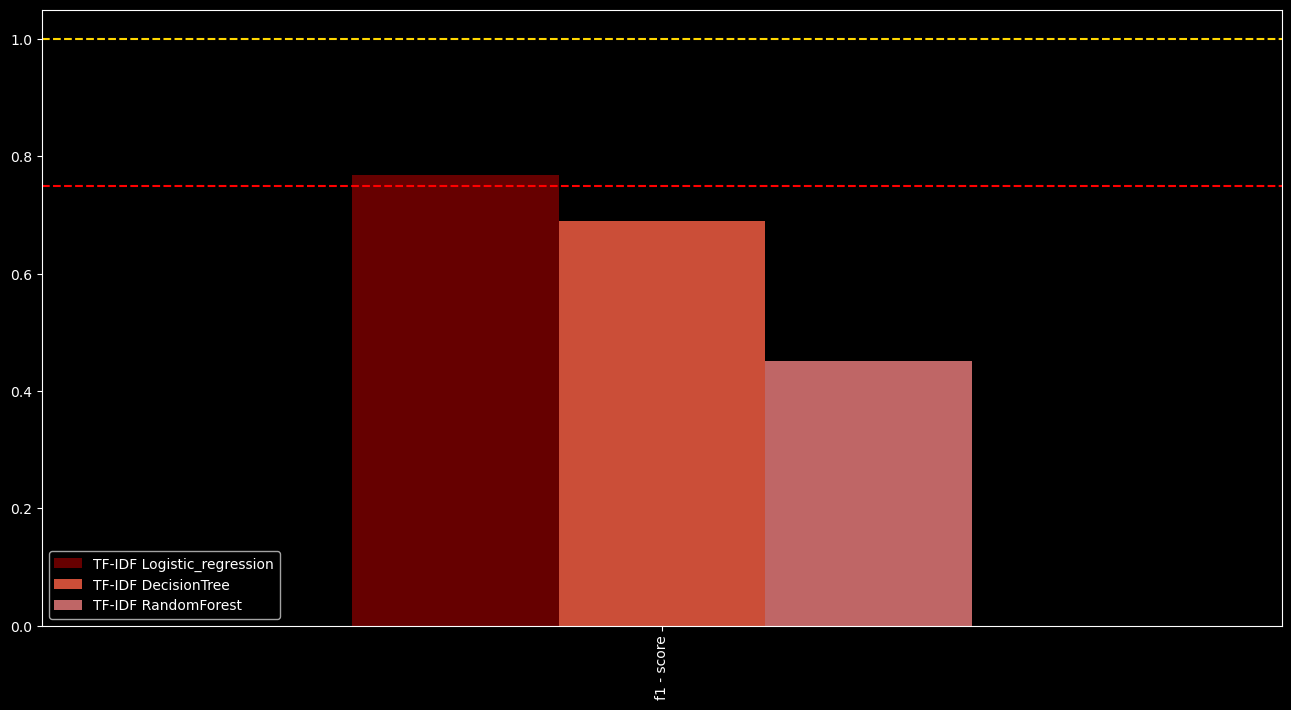

In [31]:
display(tabl)
tabl.plot(kind = 'bar', figsize= [16,8], color = color_list, alpha = 0.8)

plt.axhline(y = 0.75, color = 'red', linestyle = '--')
plt.axhline(y = 1, color = 'gold', linestyle = '--')
plt.show()

Итоги по TF-IDF

* На тренировочной выборке Logistic Regression и DecisionTree прошли порог точности f1 в 0.75


## TF-IDF Downsumpling

* Обучим идентичнные предыдущим модели на более сбалансированной по классам выборке:

In [32]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0 ]
    target_ones = target[target ==1 ]
    features_zeros_sample = features_zeros.sample(frac = fraction, random_state = 1667)
    target_zeros_sample = target_zeros.sample(frac = fraction, random_state = 1667)
    features_downsampled = pd.concat([features_zeros_sample] + [features_ones])
    features_downsampled = shuffle(features_downsampled, random_state = 1667)
    target_downsampled = pd.concat([target_zeros_sample]+ [target_ones])
    target_downsampled = shuffle(target_downsampled, random_state = 1667)
    return features_downsampled, target_downsampled

In [33]:
xl_train_down, yl_train_down = downsample(xl_train, yl_train, 0.3)

In [34]:
# создаем корпус:

corpus_train_down = xl_train_down.values
corpus_test = xl_test.values
corpus_valid = xl_valid.values

english_stopwords = stopwords.words("english")
count_tf_idf = TfidfVectorizer(stop_words = list(english_stopwords))
tf_idf_train_down = count_tf_idf.fit_transform(corpus_train_down)
tf_idf_valid_down = count_tf_idf.transform(corpus_valid)
tf_idf_test_down = count_tf_idf.transform(corpus_test)

### TF-IDF LogisticRegression DownSampling

Все модели с измененной выборкой обучаются без кросс-валидации:

In [35]:
best_score = 0



for i in [1.,2.,3.,5.,10.,15.,20.]:
    log_reg_down = LogisticRegression(random_state= rs, solver = 'lbfgs', C = i, max_iter = 1000)
    log_reg_down.fit(tf_idf_train_down, yl_train_down)
    for_predict = log_reg_down.predict(tf_idf_valid_down)
    score = f1_score(for_predict,yl_valid)
    if score > best_score:
        best_score = score
        best_log_reg_down = log_reg_down
        best_c = i

print(best_score)        
print(best_log_reg_down)
print(best_c)

0.7635991820040899
LogisticRegression(C=3.0, max_iter=1000, random_state=1667)
3.0


In [36]:
best_log_reg_down.fit(tf_idf_train_down,yl_train_down)
print(tfidf_log_reg_down_score := f1_score((best_log_reg_down.predict(tf_idf_valid_down)),yl_valid))

0.7635991820040899


### TF-IDF DecisionTree DownSampling

In [37]:
best_score = 0


for depth in [3,5,10,15,20]:
    for samples_split in [ 2,3,10]:
        for samples_leaf in [1, 2,4]:
            dec_tree = DecisionTreeClassifier(random_state= rs, max_depth= depth,min_samples_split=samples_split)
            dec_tree.fit(tf_idf_train_down, yl_train_down)
            dec_tree_pred = dec_tree.predict(tf_idf_valid_down)
            score = f1_score(dec_tree_pred,yl_valid)
            if score > best_score:
                best_score = score
                best_dec_tree_down = dec_tree
                best_depth = depth
                best_samples_split = samples_split




In [38]:
best_dec_tree_down.fit(tf_idf_train_down,yl_train_down)

DecisionTreeClassifier(max_depth=20, min_samples_split=3, random_state=1667)

In [39]:

print('F1 score: \n ')
print(tfidf_tree_down_score := f1_score((best_dec_tree_down.predict(tf_idf_valid_down)),yl_valid))


F1 score: 
 
0.6517073170731708


### TF-IDF RandomForest Dwonsampling

In [40]:
best_score = 0

for depth in [3,5,10,15,20,50,100]:
    for estimators in [3,6,9,12,20]:
        rnd_forest_down = RandomForestClassifier(random_state = rs, n_estimators = estimators, max_depth = depth)
        rnd_forest_down.fit(tf_idf_train_down, yl_train_down)
        forest_pred = rnd_forest_down.predict(tf_idf_valid_down)
        score = f1_score(forest_pred, yl_valid)
        if score > best_score:
            best_score = score
            best_forest_down = rnd_forest_down
            best_depth = depth
            best_estimators = estimators

print(best_score, best_forest_down)
print(f'depth {best_depth}, estimators: {best_estimators}')

0.6325606181721289 RandomForestClassifier(max_depth=100, n_estimators=20, random_state=1667)
depth 100, estimators: 20


In [41]:

print()
print('F1 score: \n ')
print(tfidf_forest_down_score := f1_score((best_forest_down.predict(tf_idf_valid_down)),yl_valid))



F1 score: 
 
0.6325606181721289


### Сравнение эффективности моделей

In [42]:
tabl = pd.DataFrame({'TF-IDF Logistic_regression':[ tfidf_log_score],
                  'TF-IDF DecisionTree':[ tfidf_tree_score],
                  'TF-IDF RandomForest':[ tfidf_forest_score],
                  'TF_IDF LogReg Downsamp':[tfidf_log_reg_down_score],
                  'TF-IDF DecTree Downsamp':[tfidf_tree_down_score],
                  'TF-IDF RandFOrest Downsamp':[tfidf_forest_down_score]}, index = ['f1 score'])

,TF-IDF Logistic_regression,TF-IDF DecisionTree,TF-IDF RandomForest,TF_IDF LogReg Downsamp,TF-IDF DecTree Downsamp,TF-IDF RandFOrest Downsamp
f1 score,0.768326,0.690185,0.450956,0.763599,0.651707,0.632561


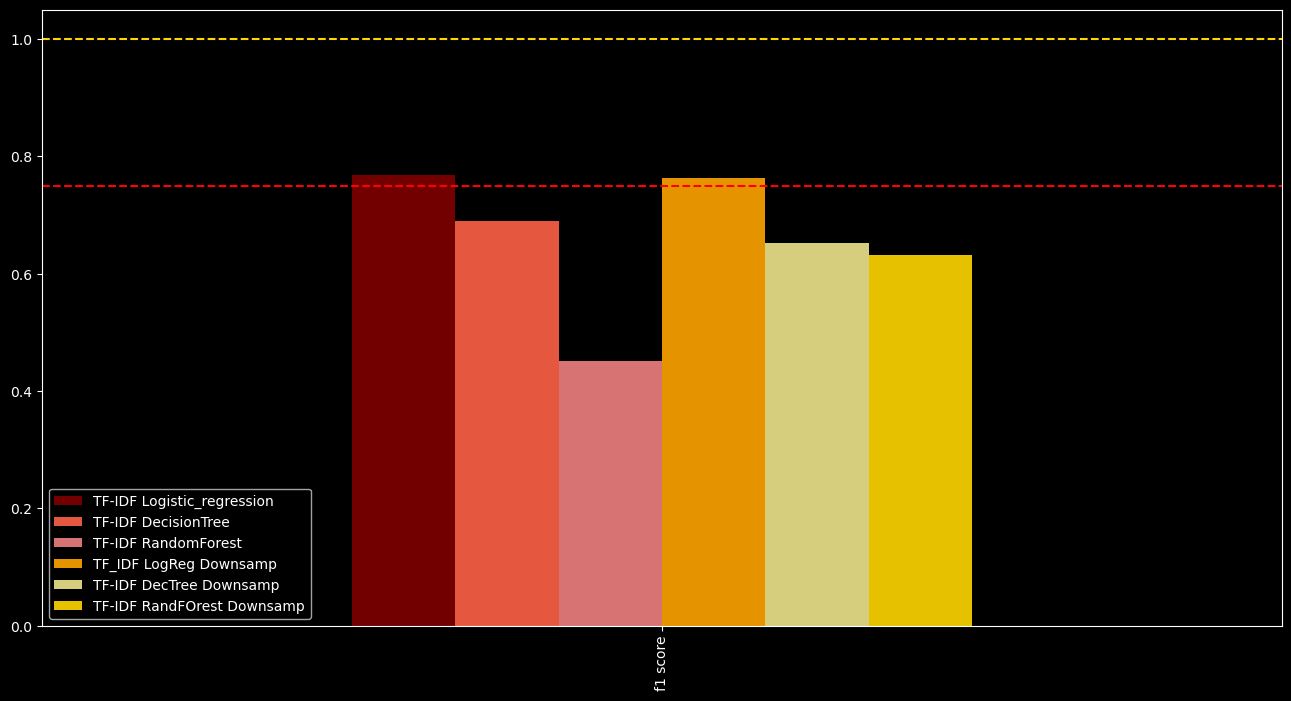

In [43]:
display(tabl)
tabl.plot(kind = 'bar', figsize = [16,8], color = color_list, alpha = 0.9)

plt.axhline(y = 0.75, color = 'red', linestyle = '--')
plt.axhline(y = 1, color = 'gold', linestyle = '--')
plt.show()


Итоги по TF-IDF с более сбалансированными классами:

* модели LogisticRegression & RandomForest на измененной Треировочной выборке(стратегия Downsampling) прошли порог F1 > 0.75

* модель LogisticRegression обученная на измененной Тренировоыной выборке(Downsampling), прошла порог F1 > 0.75  на валиации и подошла под минимальный критерий заказчика.

## PretrainedBERT

Под задачу классификуации токсичных комментариев была подобранна специально обученная под задачу модель BERT: toxic-bert

Тестирование модели BERT будет проводиться на случайном срезе выборки для экономии временного ресурса, на оборудовании без CUDA ядер.

In [44]:
# срез выборки

main = main.sample(frac = 1, random_state= rs).reset_index()
main = main[:12000]

In [45]:
try:
    tokenizer = transformers.BertTokenizer(
        vocab_file = 'E:/DL Models/Transformers/BERT/toxic-bert/vocab.txt')
except:
    tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')

In [46]:
tokenized = main['text'].apply(lambda x: tokenizer.encode(x[:512], add_special_tokens = True))

In [47]:
"""
\\\\\
Модель BERT предобучена на векторах длиной до 512,
что делает для нас невозможным использовать более длинные текста
это скажется на итоговом качестве, в сравнении с более обученной моделью,
но за неимением таковой - пойдем на шаг
и укоратим все наши вектора
/////
"""


padded = np.array([i +[0]*(512 - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0,1,0)


In [48]:
try:   
    config = transformers.BertConfig.from_json_file('E:/DL Models/Transformers/BERT/toxic-bert/config.json')
    model = transformers.BertModel.from_pretrained('E:/DL Models/Transformers/BERT/toxic-bert/pytorch_model.bin', config = config)
except:
    config = transformers.BertConfig.from_pretrained('unitary/toxic-bert')
    model = transformers.BertModel.from_pretrained('unitary/toxic-bert')

In [49]:
batch_size = 300
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        print(batch.shape)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        print(attention_mask_batch.shape)
        
        with torch.no_grad():

            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
            
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/40 [00:00<?, ?it/s]

torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size([300, 512])
torch.Size(

### Создание выборок

In [50]:
features = np.concatenate(embeddings)
target = main['toxic']

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = rs)


### LogisticRegression

In [51]:
grid_params_bert_log = {'C':[1.,2.,4.,6.,10.,15.,20.]}

params_bert_log = {'C':1}

In [52]:

log_reg = LogisticRegression(random_state= rs, C = params_bert_log['C'])

In [53]:
bert_log_grid = GridSearchCV(log_reg,grid_params_bert_log,verbose = 1, cv = 4,n_jobs= -1, scoring = 'f1')
bert_log_grid.fit(x_train, y_train)
print(bert_log_grid.best_score_)
bert_log_score = bert_log_grid.best_score_


Fitting 4 folds for each of 7 candidates, totalling 28 fits
0.9097251071891732


e:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### DecisionTree


In [54]:
params = {'max_depth':5,
          'min_samples_split': 2,
          'min_samples_leaf':2}

grid_params = {'max_depth': [5,50,150],
               'min_samples_split': [2,20,30],
               'min_samples_leaf':[2,4,6]}

In [55]:
tree_bert = DecisionTreeClassifier(max_depth= params['max_depth'],
                              min_samples_leaf=params['min_samples_leaf'],
                              min_samples_split=params['min_samples_split'])

In [56]:
bert_tree_grid = GridSearchCV(tree_bert, grid_params, verbose = 1, cv = 4,n_jobs= -1, scoring = 'f1')
bert_tree_grid.fit(x_train, y_train)
print(bert_tree_grid.best_score_)
bert_tree_score = bert_tree_grid.best_score_

Fitting 4 folds for each of 27 candidates, totalling 108 fits
0.9031513227375539


### RandomForestClassifier

In [57]:
params = {'max_depth':10,
          'n_estimators':10,
          'min_samples_split':2}

grid_params = {'max_depth':[10,20,30],
               'n_estimators':[10,40,90],
               'min_samples_split':[2,4,6]}

In [58]:
forest_bert = RandomForestClassifier(random_state = rs,
                                max_depth = params['max_depth'],
                                n_estimators=params['n_estimators'],
                                min_samples_split=params['min_samples_split'])

bert_forest_grid = GridSearchCV(forest_bert,grid_params,verbose=1, cv = 4, n_jobs = -1, scoring = 'f1')
bert_forest_grid.fit(x_train, y_train)
print(bert_forest_grid.best_score_)
bert_forest_score = bert_forest_grid.best_score_

Fitting 4 folds for each of 27 candidates, totalling 108 fits
0.9252551217226512


## Таблица всех испробованных моделей:

,TF-IDF Logistic_regression,TF-IDF DecisionTree,TF-IDF RandomForest,TF_IDF LogReg Downsamp,TF-IDF DecTree Downsamp,TF-IDF RandFOrest Downsamp,BERT LogReg,BERT DecTree,BERT RandForest
SCORE,0.768326,0.690185,0.450956,0.763599,0.651707,0.632561,0.909725,0.903151,0.925255


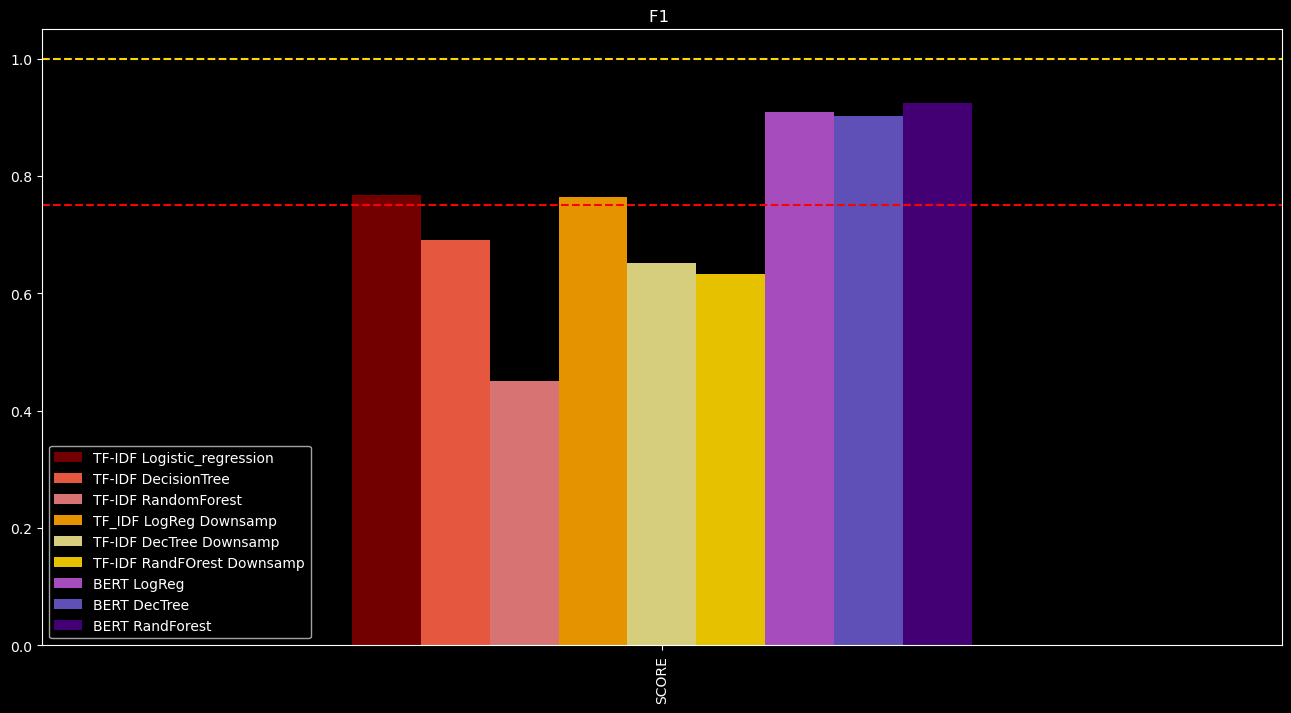

In [59]:
table_df = pd.DataFrame({'TF-IDF Logistic_regression':[ tfidf_log_score],
                  'TF-IDF DecisionTree':[ tfidf_tree_score],
                  'TF-IDF RandomForest':[ tfidf_forest_score],
                  'TF_IDF LogReg Downsamp':[tfidf_log_reg_down_score],
                  'TF-IDF DecTree Downsamp':[tfidf_tree_down_score],
                  'TF-IDF RandFOrest Downsamp':[tfidf_forest_down_score],
                  'BERT LogReg': [bert_log_score],
                  'BERT DecTree':[bert_tree_score],
                  'BERT RandForest':[bert_forest_score]}, index = ['SCORE'])



display(table_df)
table_df.plot(kind = 'bar', figsize = [16,8], color = color_list,alpha =0.9)
plt.axhline(y = 0.75, color = 'red', linestyle = '--')
plt.axhline(y = 1, color = 'gold', linestyle = '--')
plt.title('F1 ')
plt.show()

## Итоговое тестирование модели

### RandomForestClassifier With BERT

Предскажем тестовую выборку на наиболее эффективной из иследованных моделей:

In [60]:
test_forest_score = bert_forest_grid.best_estimator_.predict(x_test)
print(bert_test_score := f1_score(test_forest_score,y_test))

0.9273504273504273


### DummyModels

Для сравнения используем статичную модель.

В качестве стратегии заполнения - спрогноз будет генерироваться случайным образом из списка имеющихся классов.

In [61]:
dummy = DummyClassifier(random_state=rs, strategy= 'uniform')
dummy.fit(x_train,y_train)
dummy_pred = dummy.predict(x_test)
print(dummy_f1 := f1_score(y_test,dummy_pred))

0.16091954022988506


### Words-Markers


Второе сравнение проведем на статичной модели, которая:
1. Соберет уникальные слова, характерные только для токсичных комментариев.
2. Будет по наличию этих слов предсказывать класс комментария.

In [62]:
# тест проведем на срезе данных, чтобы увеличить скорость прогонки по двойному циклу(далее в коде)
word_data = df[:10000]

In [63]:
# создадим два множества: с уникальными словами для обычных и токсичных комментариев.

c = set(word_data.loc[word_data['toxic'] == 1].lemm_text.str.split(expand = True).stack().value_counts()[:300].index)
x = set(word_data.loc[word_data['toxic'] == 0].lemm_text.str.split(expand = True).stack().value_counts()[:1000].index)

# Найдем разность полученных множеств:

a = c.difference(x)

In [64]:
word_data.loc[:,'predict'] = 0

C:\Users\Маяк\AppData\Local\Temp\ipykernel_1540\1911261598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_data.loc[:,'predict'] = 0


In [65]:
# Присвоим класс на основе вхождения слов из найденног множества
for i in range(word_data.shape[0]):
    for st in list(a): 
        if st in word_data.loc[i,:].lemm_text.split():
            word_data.loc[i,'predict'] = 1


In [66]:
# рассчитаем точность:
print(marker_f1 := f1_score(word_data['toxic'],word_data['predict']))

0.6150537634408602


### Сравнение моделей на тесте:

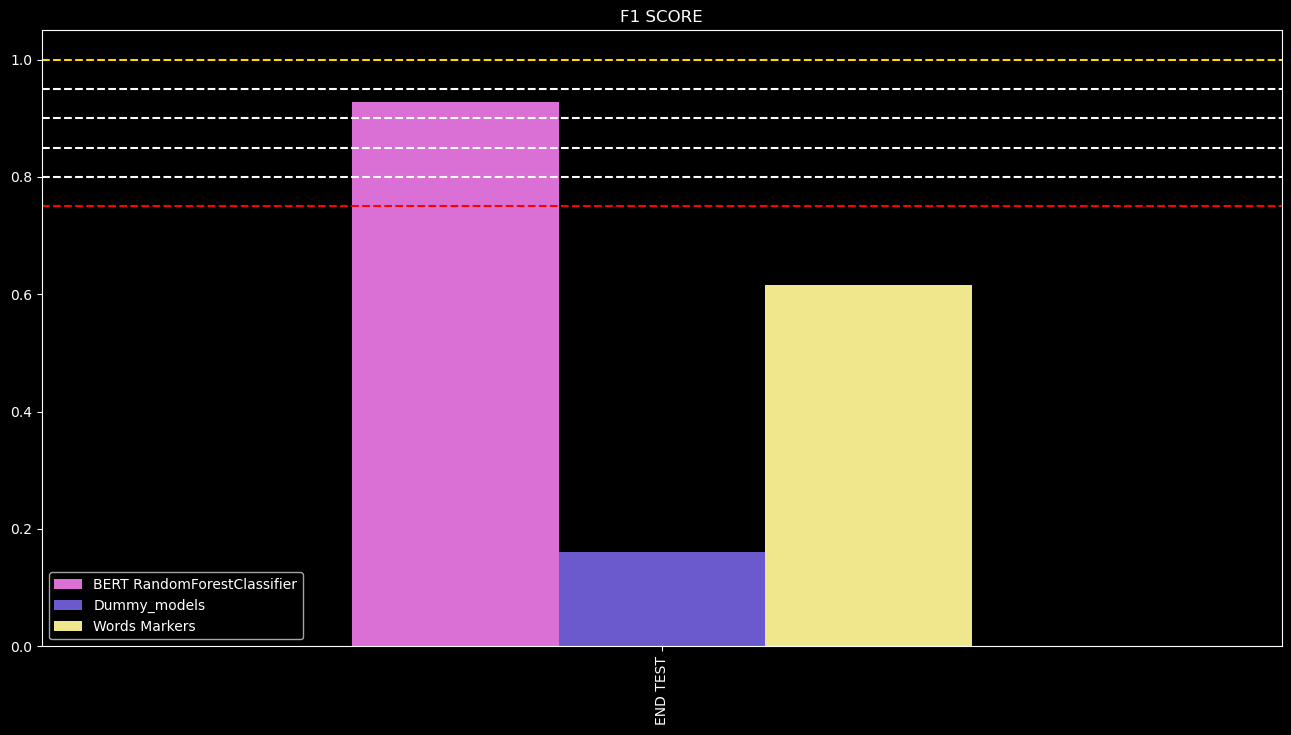

In [67]:
end_table = pd.DataFrame({'BERT RandomForestClassifier':[bert_test_score],
                         'Dummy_models':[dummy_f1],
                         'Words Markers':[marker_f1]}, index = ['END TEST'])

color_list2 = ['orchid','slateblue','khaki']

end_table.plot( kind = 'bar',figsize = [16,8], color = color_list2)



plt.axhline(y = 0.75, color = 'r', linestyle = '--')
plt.axhline(y = 0.80, color = 'w', linestyle = '--')
plt.axhline(y = 0.85, color = 'w', linestyle = '--')
plt.axhline(y = 0.90, color = 'w', linestyle = '--')
plt.axhline(y = 0.95, color = 'w', linestyle = '--')
plt.axhline(y = 1, color = 'gold', linestyle = '--')
plt.title('F1 SCORE')
plt.show()

RandomForestClassifier c BERT, на тестовой выборке:
* Прошла тест на адекватность в сравнении со статичными моделями.
* Прошла порог точности F1> 0.75 с точностью F1 = 0.918

## Итог проекта:

* В выборке, предоставленной заказчиком обнаружен дисбаланс классов.

Для классификации токсичных комментариев магазина "Викишоп" были рассмотрены следующие модели:
* Logistic Regression
* Decission Tree Classifier
* Random Forest Classifier 

На следующих преобразованиях
* TF-IDF.
* TF-IDF c измененным балансом классов(Downsampling).
* BERT (toxic-bert) предобученная специально под похожую данной задачу.

Среди рассмотренных моделей, для классификации токсичных комментариев магазина "Викишоп", наилучшей себя зарекомендовала:

* Базовая Модель **RandomForestClassifier** в связке с **TOXIC-BERT**(предобученной для разметки токсичных комментариев)

* Точность модели по метрике F1 score на следующих выборках составила:
1. Train = 0.925
3. Test = 0.927